<!-- 
# Bayesian Marketing Mix Model (MMM) — PyMC Template

This notebook implements a **Bayesian MMM** with **adstock (carry-over)**, optional **trend/seasonality**, and produces **ROI** and **channel insights**.
Use it as a starting point for the HAMS Data Science Challenge.

**What you'll get:**
- Prior choices explained inline
- Prior vs posterior predictive checks
- WAIC/LOO model diagnostics
- ROI per channel with uncertainty
- Clean, modular code you can extend -->


In [21]:

# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import pytensor
import pytensor.tensor as pt
from pathlib import Path

az.style.use('arviz-darkgrid')
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 50)


In [22]:

# --- Load data ---
DATA_PATH = 'MMM_test_data.csv'

df = pd.read_csv(DATA_PATH)
# Ensure consistent dtypes
if 'start_of_week' in df.columns:
    df['start_of_week'] = pd.to_datetime(df['start_of_week'])
    df = df.sort_values('start_of_week').reset_index(drop=True)

# Identify columns
y_col = 'revenue'
spend_cols = [c for c in df.columns if c.startswith('spend_channel_')]

print('Rows:', len(df), '| Channels:', len(spend_cols))
print('Spend columns:', spend_cols[:10])
df.head()


Rows: 104 | Channels: 7
Spend columns: ['spend_channel_1', 'spend_channel_2', 'spend_channel_3', 'spend_channel_4', 'spend_channel_5', 'spend_channel_6', 'spend_channel_7']


C:\Users\User\AppData\Local\Temp\ipykernel_900\376690045.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_of_week'] = pd.to_datetime(df['start_of_week'])


,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,2020-01-11,213117.17,370.19,98.93,24509.24,4982.32,8945.98,7837.48,17768.76
1,2020-04-10,195581.04,3655.19,525.06,18024.45,9739.47,20804.05,25445.63,30394.41
2,2020-06-09,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
3,2020-06-12,150423.19,1372.79,141.30,10183.94,7226.42,14808.32,14997.14,20745.24
4,2020-08-11,202321.02,1723.65,136.25,35550.52,4847.53,14683.10,12213.42,25127.60


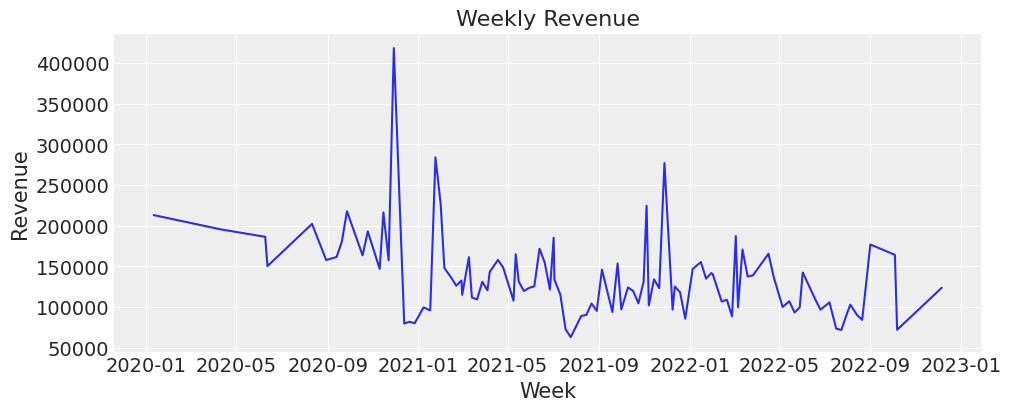

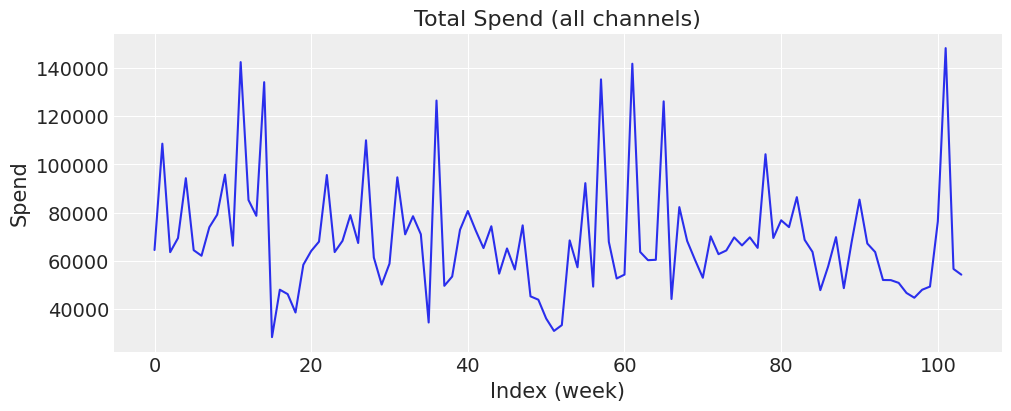

In [23]:

fig, ax = plt.subplots(figsize=(10,4))
if 'start_of_week' in df.columns:
    ax.plot(df['start_of_week'], df[y_col])
    ax.set_xlabel('Week')
else:
    ax.plot(df.index, df[y_col])
    ax.set_xlabel('Index (week)')
ax.set_ylabel('Revenue')
ax.set_title('Weekly Revenue')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df[spend_cols].sum(axis=1))
ax.set_title('Total Spend (all channels)')
ax.set_xlabel('Index (week)')
ax.set_ylabel('Spend')
plt.show()



## Adstock (Carry-over) Modeling


In [7]:

def adstock_scan(x, alpha):
    """Return adstocked series for vector x using scalar alpha in (0,1)."""
    x_tt = pt.as_tensor_variable(x)
    def step(curr, prev, alpha):
        return curr + alpha * prev
    outputs, _ = pytensor.scan(fn=step, sequences=[x_tt], outputs_info=[pt.zeros_like(x_tt[0])], non_sequences=[alpha])
    return outputs


In [8]:

# --- Build design matrix ---
y = df[y_col].values.astype(float)
X = df[spend_cols].values.astype(float)

# Standardize predictors for more stable sampling (keep scale for ROI later)
X_mean = X.mean(axis=0, keepdims=True)
X_std = X.std(axis=0, keepdims=True) + 1e-8
X_s = (X - X_mean) / X_std

n, k = X_s.shape
print(f'n={n}, k={k}')


n=104, k=7


In [18]:

# Simple linear trend
t = np.arange(n)
t_s = (t - t.mean()) / t.std()



## PyMC Model


In [10]:

coords = {
    'week': np.arange(n),
    'channel': spend_cols,
}

y_mean = y.mean()
y_sd   = y.std()

with pm.Model(coords=coords) as mmm:
    # Data
    X_shared = pm.Data('X_s', X_s)
    y_shared = pm.Data('y', y)
    t_shared = pm.Data('t_s', t_s)

    # Priors (anchored to data scale)
    beta0 = pm.Normal('beta0', mu=y_mean, sigma=3*y_sd)       # intercept around mean revenue
    beta  = pm.HalfNormal('beta', sigma= y_sd/10, dims='channel')  # non-negative effects
    alpha = pm.Beta('alpha', alpha=2.0, beta=2.0, dims='channel')  # adstock decay in (0,1)
    gamma = pm.Normal('gamma', mu=0.0, sigma=y_sd/10)          # gentle trend
    sigma = pm.HalfNormal('sigma', sigma=y_sd)                 # noise on revenue scale

    # Adstock per channel
    adstocked = []
    for i in range(k):
        ad_i = adstock_scan(X_shared[:, i], alpha[i])
        adstocked.append(ad_i)
    A = pt.stack(adstocked, axis=1)

    mu = beta0 + (A * beta).sum(axis=1) + gamma * t_shared

    y_like = pm.StudentT('y_like', nu=4, mu=mu, sigma=sigma, observed=y_shared, dims='week')

    # Sampling (Windows-friendly)
    prior     = pm.sample_prior_predictive(draws=100, random_seed=42)
    trace     = pm.sample(
        tune=600, draws=600,
        chains=2, cores=1,
        init="adapt_diag",
        target_accept=0.95,
        random_seed=[42, 43],
        progressbar=True,
    )
    post_pred = pm.sample_posterior_predictive(trace, random_seed=42)

print("Sampling finished.")


Sampling: [alpha, beta, beta0, gamma, sigma, y_like]
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\pymc\sampling\mcmc.py:757: UserWarning: A list or tuple of random_seed no longer specifies the specific random_seed of each chain. Use a single seed instead.
  warnings.warn(
Initializing NUTS using adapt_diag...
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\pytensor\link\c\cmodule.py:2986: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configur

Output()

Sampling 2 chains for 600 tune and 600 draw iterations (1_200 + 1_200 draws total) took 636 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_like]


Output()

Sampling finished.


In [19]:

# --- Diagnostics ---
az.summary(trace, var_names=['beta','alpha','gamma','sigma'])



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[spend_channel_1],1852.558,1592.503,0.715,4731.011,44.578,48.723,901.0,453.0,1.00
beta[spend_channel_2],2496.057,2014.932,8.470,6164.910,58.591,53.666,907.0,523.0,1.00
beta[spend_channel_3],4621.239,2736.033,112.545,9244.591,91.012,58.248,798.0,556.0,1.00
beta[spend_channel_4],2746.426,2048.301,5.877,6417.292,62.698,61.800,806.0,602.0,1.00
beta[spend_channel_5],5686.072,2872.037,37.031,10386.367,84.950,70.414,969.0,591.0,1.00
beta[spend_channel_6],8548.791,2985.858,3211.950,14289.800,99.604,90.999,843.0,445.0,1.00
beta[spend_channel_7],7359.108,3026.246,1796.415,12736.324,86.465,78.142,1197.0,814.0,1.00
alpha[spend_channel_1],0.433,0.209,0.073,0.791,0.006,0.004,1366.0,779.0,1.00
alpha[spend_channel_2],0.423,0.213,0.042,0.802,0.006,0.005,1421.0,794.0,1.00
alpha[spend_channel_3],0.359,0.229,0.024,0.822,0.007,0.007,1278.0,633.0,1.00



## ROI per Channel

In [13]:

post = trace.posterior
beta_post  = post["beta"].stack(sample=("chain","draw")).values   
alpha_post = post["alpha"].stack(sample=("chain","draw")).values  
X_std_vec  = X_std.flatten()                                      

# Long-run multiplier and ROI per sample
roi = []
for i in range(k):
    lr_mult = 1.0 / (1.0 - alpha_post[i])            
    roi_i = beta_post[i] * lr_mult / X_std_vec[i]
    roi.append(roi_i)
roi = np.array(roi)                                    

roi_mean = roi.mean(axis=1)                         
roi_low  = np.quantile(roi, 0.05, axis=1)             
roi_high = np.quantile(roi, 0.95, axis=1)             

roi_df = pd.DataFrame({
    "channel": spend_cols,
    "ROI_mean": roi_mean,
    "ROI_hdi_low": roi_low,
    "ROI_hdi_high": roi_high,
}).sort_values("ROI_mean", ascending=False)

roi_df


,channel,ROI_mean,ROI_hdi_low,ROI_hdi_high
1,spend_channel_2,13.834622,0.986416,33.547971
0,spend_channel_1,2.567601,0.173230,6.964372
5,spend_channel_6,2.425622,1.012967,3.984070
3,spend_channel_4,2.164932,0.186549,6.055957
4,spend_channel_5,1.395051,0.324735,2.688580
2,spend_channel_3,1.040043,0.170532,2.113023
6,spend_channel_7,0.933522,0.381441,1.603897


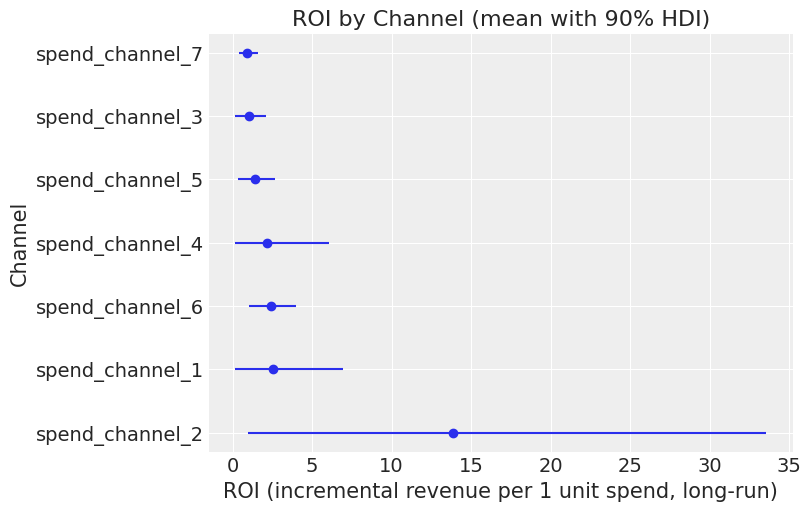

In [14]:

# --- Plot ROI rankings ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(roi_df['ROI_mean'], roi_df['channel'], 
            xerr=[roi_df['ROI_mean'] - roi_df['ROI_hdi_low'], roi_df['ROI_hdi_high'] - roi_df['ROI_mean']], 
            fmt='o')
ax.set_xlabel('ROI (incremental revenue per 1 unit spend, long-run)')
ax.set_ylabel('Channel')
ax.set_title('ROI by Channel (mean with 90% HDI)')
plt.show()


In [15]:

alpha_mean = trace.posterior["alpha"].mean(dim=("chain","draw")).values  # (k,)
beta_mean  = trace.posterior["beta"].mean(dim=("chain","draw")).values   # (k,)

def adstock_np(x, alpha):
    out = np.zeros_like(x, dtype=float)
    out[0] = x[0]
    for t in range(1, len(x)):
        out[t] = x[t] + alpha * out[t-1]
    return out

contrib = {}
for i, ch in enumerate(spend_cols):
    ad_i = adstock_np(X_s[:, i], float(alpha_mean[i]))    
    contrib[ch] = ad_i * float(beta_mean[i])                

contr_df = pd.DataFrame(contrib, index=df.index)
contr_df["total"] = contr_df.sum(axis=1)
contr_df.head()

,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,total
0,-1173.745400,-1843.219785,2665.325030,-1707.893228,304.183591,3561.910821,-6032.139946,-4225.578917
1,2722.551911,586.444389,165.714099,1719.947149,10161.596162,27761.315632,-335.521283,42782.048059
2,3040.325310,-1521.749389,-5667.008985,-1299.346400,7381.254541,21719.386770,-3284.582588,20368.279259
3,1486.881704,-2168.079586,-7000.017941,-315.097303,7991.579766,22439.930744,-5297.753099,17137.444284
4,1284.724317,-2479.642658,6038.430369,-1970.113135,8126.264752,19186.526548,-3294.127116,26892.063077


In [27]:

# --- Save key outputs ---
out_dir = Path('mmm_outputs')
out_dir.mkdir(exist_ok=True)

roi_csv = out_dir / 'roi_by_channel.csv'
roi_df.to_csv(roi_csv, index=False)

print('Saved:', roi_csv.resolve())


Saved: C:\Users\User\Desktop\HAMS_MMM_Challenge\mmm_outputs\roi_by_channel.csv
